# NCAA Football Coach Salary Analysis

## Abstract

The goal of this project was to make a recommendation on the Syracuse head football coaches' salary using linear regression. The initial dataset given was a list of NCAA coaches, their university, football conference and their pay including salary and bonuses. The real challenge was in defining the additional variables to be used in the salary analysis, sourcing them and incorporating them into the dataset. This project demonstrates using linear regression as well as the process of data wrangling. 

## Importing and Cleaning Data

The majority of the time spent on this project involved defining, sourcing and integrating datasets with the coaches salary. The data that was added to the data is as follows:

* Student Athlete Graduation Rate
    * TSV File Download and Import
    * Sourced from Inter-University Consortium for Political and Social Research
* Program Win-Loss Record
    * Parsehub API Web-Scraping Tool / CSV Download and Import
    * NCAA Website
* Football Program Revenue
    * CSV Download and Import
    * U.S. Department of Education
* Football Stadium Capacity
    * Parsehub API Web-Scraping Tool / CSV Download and Import
    * Wikipedia

In [355]:
import os

os.chdir('/Users/coreylucero/Desktop/Syracuse/IST718/Lab 1')

# Import pandas
import pandas as pd # used to load in data
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plot

### Coach Salary Dataset

The provided dataset included salaries from most NCAA coaches, however a few of them were left blank. This was a small enough dataset that I was able to source the figures through articles or IRS forms.

In [7]:

file = '/Users/coreylucero/Desktop/Syracuse/IST718/Lab 1/Coaches_2_2_2.xlsx'

xl = pd.ExcelFile(file)
df1 = xl.parse('Coaches') #Save sheet within excel file as a dataframe

#Identify missing values

print('Salary:',(df1['Salary'].isna()).sum())
print('Other Pay:',(df1['OtherPay'].isna()).sum())
print('Total Salary:',(df1['TotalSalary'].isna()).sum())
print('Max Bonus:',(df1['MaxBonus'].isna()).sum())

['Coaches']


,Name,School,Conference,Salary,OtherPay,TotalSalary,MaxBonus
0,Steve Addazio,Temple,Big East,NaN,NaN,NaN,NaN
1,Robb Akey,Idaho,WAC,375797.0,6200.0,381997.0,158262.0
2,Gary Andersen,Utah State,WAC,415000.0,0.0,415000.0,150000.0
3,Chris Ault,Nevada,Mt. West,493093.0,0.0,493093.0,30000.0
4,David Bailiff,Rice,CUSA,608846.0,NaN,608846.0,NaN
5,Frank Beamer,Virginia Tech,ACC,2343000.0,85000.0,2428000.0,407500.0
6,Tim Beckman,Illinois,Big Ten,1600000.0,NaN,1600000.0,80000.0
7,Todd Berry,Louisiana-Monroe,Sun Belt,250000.0,NaN,250000.0,62500.0
8,Bret Bielema,Wisconsin,Big Ten,2600000.0,40140.0,2640140.0,400000.0
9,Larry Blakeney,Troy,Sun Belt,455000.0,0.0,455000.0,75000.0


In [7]:
#Show the coaches that don't have Salary data
print(df1.loc[df1['Salary'].isna()])

                  Name         School Conference  Salary  OtherPay  \
0        Steve Addazio         Temple   Big East     NaN       NaN   
10    Bill Blankenship          Tulsa       CUSA     NaN       NaN   
19         Paul Chryst     Pittsburgh   Big East     NaN       NaN   
42      James Franklin     Vanderbilt        SEC     NaN       NaN   
45           Al Golden          Miami        ACC     NaN       NaN   
59      Curtis Johnson         Tulane       CUSA     NaN       NaN   
79   Bronco Mendenhall  Brigham Young       Ind.     NaN       NaN   
105         David Shaw       Stanford     PAC-12     NaN       NaN   

     TotalSalary  MaxBonus  
0            NaN       NaN  
10           NaN       NaN  
19           NaN       NaN  
42           NaN       NaN  
45           NaN       NaN  
59           NaN       NaN  
79           NaN       NaN  
105          NaN       NaN  


Once I was able to identify which coaches were missing salary data, I was able to source this information online.

* Steve Addazio
    * 1,201,771 per season
    * Temple 2012 IRS Form 990 - Top 25 highest paid employees
* Bill Blankenship
    * 625,000 per season
    * News Article
* Paul Chryst
    * 1,578,757 per season
    * USA Today Salaries
* James Franklin
    * 1,547,682 base salary/ 295,089 other / 1,842,771 total / 50,000 bonus
    * Article
* Al Golden
    * 2,539,315 per season
    * Article
* Curtis Johnson
    * 1,000,000 per season
    * Article
* Bronco Mendenhall
    * 1,500,000 per season
    * Article
* David Shaw
    * 5,680,441 per season
    * USA Today Salaries


In [8]:
#Replace NAs with found data

df1.iloc[0,3] = 1201771 

df1.iloc[10,3] = 625000

df1.iloc[19,3] = 1578757

df1.iloc[42,3] = 1547682
df1.iloc[42,4] = 295089
df1.iloc[42,5] = 1842771
df1.iloc[42,6] = 50000

df1.iloc[45,3] = 2539315

df1.iloc[59,3] = 1000000

df1.iloc[79,3] = 1500000

df1.iloc[105,3] = 5680441

print('Salary:',(df1['Salary'].isna()).sum()) #Make sure there are no more NAs in Salary - should = 0

Salary: 0


### Student Athlete Graduation Rate

Next the Student Athlete Graduate Rate data was imported, isolated to only relevant information and an attempt was made to merge this with the original dataset. This highlighted an additional challenge in preprocessing - colleges and universities have too many variations on their name for a simple join or merge statement to work. To solve this problem, I turned to the FuzzyWuzzy package which got the majority combined. The few remaining that even FuzzyWuzzy couldn't find I had to alter manually.

In [9]:
# Read in graduation rate data
from pandas import DataFrame
GSRdf = pd.read_csv("30022-0004-Data.tsv", sep="\t", index_col=0)

#Subset only the school name and graduation rate for latest school year available
GSRdf = GSRdf[['SCL_NAME', 'GSR_2008_SA']]

# Merge main df (df1) and graduation rate dataframe (GSRdf) 
Merged1 = df1.merge(GSRdf, 
                        left_on='School', 
                        right_on='SCL_NAME', 
                        how='left' 
                       )
#Selecting people with missing salaries
missing_gradrates = Merged1[Merged1.GSR_2008_SA.isnull()]

#Nearly all were missing, so we turn to fuzzywuzzy 

In [11]:
#Load fuzzywuzzy and create a function to calculate fuzzy ratios for each school name 
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

def match_name(name, list_names, min_score=0):
    # -1 score in case we don't get any matches
    max_score = -1
    # Returning empty name for no match as well
    max_name = ""
    # Iterating over all names in the other
    for name2 in list_names:
        #Finding fuzzy match score
        score = fuzz.token_set_ratio(name, name2)
        # Checking if we are above our threshold and have a better score
        if (score > min_score) & (score > max_score):
            max_name = name2
            max_score = score
    return (max_name, max_score)

In [12]:
# List for dicts for easy dataframe creation
dict_list = []
# Apply the function 
for name in missing_gradrates.School:
    # Use function to find best match, and set threshold to 80%
    match = match_name(name, GSRdf.SCL_NAME, 80)
    
    # Store data from loop into a dictionary
    dict_ = {}
    dict_.update({"School" : name})
    dict_.update({"match_name" : match[0]})
    dict_.update({"score" : match[1]})
    dict_list.append(dict_)

#Convert dictionary to a dataframe
merge_table = pd.DataFrame(dict_list)

In [99]:
#The table shows there are still issues
#Export table to excel sheet to review
#writer = ExcelWriter('mergedtable.xlsx')
#merge_table.to_excel(writer,'Sheet1',index=False)
#writer.save()

NameError: name 'ExcelWriter' is not defined

In [14]:
#Made changes directly to Excel file - Army to United States Military Academy; University of Texas - El Paso to Austin; LSU to Louisiana State University, etc..
file2 = 'mergedtable.xlsx'

x2 = pd.ExcelFile(file2)

merge_table = x2.parse('Sheet1') #Save sheet within excel file as a dataframe

['Sheet1']


,School,match_name,score
0,Temple,Temple University,100
1,Idaho,University of Idaho,100
2,Utah State,Utah State University,100
3,Nevada,University of Nevada-Reno,100
4,Rice,Rice University,100
5,Virginia Tech,Virginia Polytechnic Institute and State Unive...,-1
6,Illinois,University of Illinois at Urbana-Champaign,100
7,Louisiana-Monroe,University of Louisiana at Monroe,100
8,Wisconsin,University of Wisconsin-Green Bay,100
9,Troy,Troy University,100


In [15]:
# Merge main df (df1) and updated school table(merge_table) to include matched_name column  
Merged2 = df1.merge(merge_table, 
                        left_on='School', 
                        right_on='School', 
                        how='left',
                        suffixes=["","_matched"]
                       )

# Merge updated school table (Merged 2) with graduation rate data (GSRdf) using matched_name column 
Merge3 = Merged2.merge(GSRdf, 
                        left_on='match_name', 
                        right_on='SCL_NAME', 
                        how='left' 
                       )

#See if there are still any missing
missing_gradrates = Merge3[Merge3.GSR_2008_SA.isnull()]

#Displaying results
missing_gradrates.reset_index(inplace=True,drop='index')
missing_gradrates

,Name,School,Conference,Salary,OtherPay,TotalSalary,MaxBonus,match_name,score,SCL_NAME,GSR_2008_SA
0,Frank Spaziani,Boston College,ACC,1094976.0,NaN,1094976.0,NaN,NaN,NaN,NaN,NaN


In [16]:
#Identified one NA
#Add Boston College graduation rate after referencing GSRdf data
Merge3.iloc[109,10] = 94
Merge3.iloc[114,10] = 83
Merge3.iloc[8,10] = 87
#Confirm once more
missing_gradrates = Merge3[Merge3.GSR_2008_SA.isnull()]

#Displaying results
missing_gradrates.reset_index(inplace=True,drop='index')
missing_gradrates

#All schools are accounted for

,Name,School,Conference,Salary,OtherPay,TotalSalary,MaxBonus,match_name,score,SCL_NAME,GSR_2008_SA


In [17]:
#Drop unneccessary columns and rename graduation rate column to something more human readable
df1 = Merge3.drop(Merge3.columns[[8, 9]], axis=1)
df1.rename(columns={'GSR_2008_SA': 'Grad_Rate'}, inplace=True)
df1.head()

,Name,School,Conference,Salary,OtherPay,TotalSalary,MaxBonus,match_name,Grad_Rate
0,Steve Addazio,Temple,Big East,1201771.0,NaN,NaN,NaN,Temple University,86.0
1,Robb Akey,Idaho,WAC,375797.0,6200.0,381997.0,158262.0,University of Idaho,75.0
2,Gary Andersen,Utah State,WAC,415000.0,0.0,415000.0,150000.0,Utah State University,88.0
3,Chris Ault,Nevada,Mt. West,493093.0,0.0,493093.0,30000.0,University of Nevada-Reno,76.0
4,David Bailiff,Rice,CUSA,608846.0,NaN,608846.0,NaN,Rice University,95.0


### Stadium Capacity Dataset

The stadium capacity dataset was fairly straightforward. A few stadium capacity numbers were NA so these were sourced and inserted separately.

In [18]:
# Read in stadium data
file2 = 'StadiumData.xlsx'

x2 = pd.ExcelFile(file2)

print(x2.sheet_names)

Stadf = x2.parse('Sheet1') #Save sheet within excel file as a dataframe
Stadf.head(5) # Preview first 10 rows of dataframe

['Sheet1']


,stadium,city,state,team,conference,capacity,built,expanded,div,latitude,longitude
0,Michigan Stadium,Ann Arbor,MI,Michigan,Big Ten,107601,1927,2015,fbs,42.265869,-83.748726
1,Beaver Stadium,University Park,PA,Penn State,Big Ten,106572,1960,2001,fbs,40.812153,-77.856202
2,Ohio Stadium,Columbus,OH,Ohio State,Big Ten,104944,1922,2014,fbs,40.001686,-83.019728
3,Kyle Field,College Station,TX,Texas A&M,SEC,102733,1927,2015,fbs,30.610098,-96.340729
4,Neyland Stadium,Knoxville,TN,Tennessee,SEC,102455,1921,2010,fbs,35.954734,-83.925333
5,Tiger Stadium,Baton Rouge,LA,LSU,SEC,102321,1924,2014,fbs,30.412012,-91.183820
6,Bryant–Denny Stadium,Tuscaloosa,AL,Alabama,SEC,101821,1929,2010,fbs,33.207490,-87.550392
7,Darrell K Royal–Texas Memorial Stadium,Austin,TX,Texas,Big 12,100119,1924,2009,fbs,30.283603,-97.732337
8,Los Angeles Memorial Coliseum,Los Angeles,CA,Southern California,Pac-12,93607,1923,2008,fbs,34.014010,-118.287896
9,Sanford Stadium,Athens,GA,Georgia,SEC,92746,1929,2004,fbs,33.949821,-83.373442


In [19]:
# Merge main df (df1) and stadium data (Stadf)  
StaMerge = df1.merge(Stadf, 
                        left_on='School', 
                        right_on='team', 
                        how='left' 
                       )
#Select people with missing stadium capacities
missing_stadium = StaMerge[StaMerge.team.isnull()]
#Alabama at birmingham identified as NA

#Drop unneccessary columns and rename capacity column to something more human readable
df1 = StaMerge.drop(StaMerge.columns[[9, 12, 13, 15, 16, 17]], axis=1)
df1.rename(columns={'capacity': 'Stadium_Capacity'}, inplace=True)

#71954 - Alabama at birmingham
df1.iloc[77,10] = 71954

### Football Program Revenue Dataset

In [20]:
# Read in revenue data
#Source: https://ope.ed.gov/athletics/
file2 = 'Sport_Data_2016.csv'
Revdf = pd.read_csv(file2, index_col=None, parse_dates=True)
Revdf = Revdf[['Institution Name', 'Revenues Men\'s Team']]
Revdf.rename(columns={'Institution Name': 'InstitutionName', 'Revenues Men\'s Team': 'Revenue'}, inplace=True)
Revdf.head(5)

,InstitutionName,Revenue
0,Appalachian State University,7923498
1,Arizona State University-Tempe,43012682
2,Arkansas State University-Main Campus,7159248
3,Auburn University,91652926
4,Ball State University,7044512
5,Baylor University,43223215
6,Boise State University,21302390
7,Boston College,28487714
8,Bowling Green State University-Main Campus,6537321
9,Brigham Young University-Provo,26116548


In [21]:
# Read in data to be used as merge table for team names
# Source: ParseHub pull of Wikipedia
file2 = 'run_results.csv'
Tnames = pd.read_csv(file2, index_col=None, parse_dates=True)
Tnames.head(5)

,selection1_name,selection1_team_name,selection1_city,selection1_state
0,Air Force,Falcons,Colorado Springs,Colorado
1,Akron,Zips,Akron,Ohio
2,Alabama,Crimson Tide,Tuscaloosa,Alabama
3,UAB,Blazers,Birmingham,Alabama
4,Appalachian State,Mountaineers,Boone,North Carolina
5,Arizona,Wildcats,Tucson,Arizona
6,Arizona State,Sun Devils,Tempe,Arizona
7,Arkansas,Razorbacks,Fayetteville,Arkansas
8,Arkansas State,Red Wolves,Jonesboro,Arkansas
9,Army West Point,Black Knights,West Point,New York


In [22]:
df1.iloc[114,7] = 'Texas A & M University-College Station'
df1.iloc[77,9] = 'Birmingham'
df1.iloc[77,10] = 'AL'
df1.iloc[77,11] = 71954
df1.iloc[77,12] = float(32.20)
df1.iloc[77,13] = float(-77.94)

# Merge main df (df1) and graduation rate dataframe (GSRdf) 
RevMerge = df1.merge(Revdf, 
                        left_on='match_name', 
                        right_on='InstitutionName', 
                        how='left' 
                       )

RevMerge.iloc[8,15] = 73548409
RevMerge.iloc[109,15] = 28487714

df1 = RevMerge

,Name,School,Conference,Salary,OtherPay,TotalSalary,MaxBonus,match_name,Grad_Rate,city,state,Stadium_Capacity,latitude,longitude,InstitutionName,Revenue
0,Steve Addazio,Temple,Big East,1201771.0,NaN,NaN,NaN,Temple University,86.0,Philadelphia,PA,68532.0,39.900749,-75.167491,Temple University,20624125.0
1,Robb Akey,Idaho,WAC,375797.0,6200.0,381997.0,158262.0,University of Idaho,75.0,Moscow,ID,16000.0,46.726350,-117.017552,University of Idaho,7283199.0
2,Gary Andersen,Utah State,WAC,415000.0,0.0,415000.0,150000.0,Utah State University,88.0,Logan,UT,25513.0,41.751532,-111.812106,Utah State University,8981573.0
3,Chris Ault,Nevada,Mt. West,493093.0,0.0,493093.0,30000.0,University of Nevada-Reno,76.0,Reno,NV,30000.0,39.546925,-119.817560,University of Nevada-Reno,9730719.0
4,David Bailiff,Rice,CUSA,608846.0,NaN,608846.0,NaN,Rice University,95.0,Houston,TX,47000.0,29.716234,-95.409265,Rice University,12001178.0


### Football Win-Loss Record Dataset

Once the data was scraped from the NCAA website, it required some additional cleaning. The win-loss record was written as #-#, so I needed to separate these into their own columns and calculate the actual w/l ratio.

In [23]:
# Read in win-loss data
# Source: ParseHub pull of NCAA website
file2 = 'run_results_record.csv'
Record = pd.read_csv(file2, index_col=None, parse_dates=True)
Record.head(5)

,selection1_name,selection1_w_l
0,Clemson,12-2
1,North Carolina State,9-4
2,Louisville,8-5
3,Wake Forest,8-5
4,Boston College,7-6


In [24]:
#Split w-l into two columns and change datatypes
Record['Wins'], Record['Losses'] = Record['selection1_w_l'].str.split('-', 1).str
Record = Record.drop(Record.columns[[1]], axis=1)
Record['Wins'] = Record['Wins'].astype(float)
Record['Losses'] = Record['Losses'].astype(float)

#Create win percentage column from win/loss calculation
Record['WLPct'] = Record['Wins']/(Record['Wins'] + Record['Losses'])

# Merge main df (df1) and graduation rate dataframe (GSRdf) 
RecordMerge = df1.merge(Record, 
                        left_on='School', 
                        right_on='selection1_name', 
                        how='left' 
                       )

#Drop unneccessary columns
df1 = RecordMerge.drop(RecordMerge.columns[[16, 17, 18]], axis=1)

df1 = df1.drop(df1.columns[[7, 14]], axis=1)

In [29]:
#Export table to excel sheet
writer = pd.ExcelWriter('CoachesClean.xlsx')
df1.to_excel(writer,'Sheet1',index=False)
writer.save()

In [30]:
#Made changes directly to Excel file - Army to United States Military Academy; University of Texas - El Paso to Austin; LSU to Louisiana State University, etc..
file2 = 'CoachesClean.xlsx'

x2 = pd.ExcelFile(file2)

print(x2.sheet_names)

df1 = x2.parse('Sheet1') #Save sheet within excel file as a dataframe

['Sheet1']


,Name,School,Conference,Salary,OtherPay,TotalSalary,MaxBonus,Grad_Rate,city,state,Stadium_Capacity,latitude,longitude,Revenue,WLPct
0,Steve Addazio,Temple,Big East,1201771,NaN,NaN,NaN,86,Philadelphia,PA,68532,39.900749,-75.167491,20624125.0,0.538462
1,Robb Akey,Idaho,WAC,375797,6200.0,381997.0,158262.0,75,Moscow,ID,16000,46.726350,-117.017552,7283199.0,0.333333
2,Gary Andersen,Utah State,WAC,415000,0.0,415000.0,150000.0,88,Logan,UT,25513,41.751532,-111.812106,8981573.0,0.461538
3,Chris Ault,Nevada,Mt. West,493093,0.0,493093.0,30000.0,76,Reno,NV,30000,39.546925,-119.817560,9730719.0,0.250000
4,David Bailiff,Rice,CUSA,608846,NaN,608846.0,NaN,95,Houston,TX,47000,29.716234,-95.409265,12001178.0,0.083333


## Initial Data Exploration

Once the complete dataframe was created, I started the analysis by exploring and visualizing the data using several techniques.

In [91]:
pd.options.display.float_format = '{:.2f}'.format #Change float format to suppress scientific notation
df1.describe() #Show descriptive statistics of numeric variables

,Salary,OtherPay,TotalSalary,MaxBonus,Grad_Rate,Stadium_Capacity,latitude,longitude,Revenue,WLPct,runiform
count,124.00,75.00,117.00,105.00,124.00,124.00,124.00,124.00,117.00,124.00,124.00
mean,1606215.11,29427.23,1600448.14,518537.98,84.87,52703.15,36.88,-92.91,34794267.27,0.52,0.53
std,1184399.66,121702.18,1161112.49,428156.12,6.55,22985.67,5.03,14.84,29272049.16,0.21,0.28
min,250000.00,0.00,250000.00,25000.00,68.00,16000.00,21.37,-157.93,5394664.00,0.00,0.01
25%,587500.00,0.00,550000.00,158262.00,81.00,32186.00,33.11,-97.78,10046711.00,0.40,0.31
50%,1405823.00,1550.00,1461646.00,407500.00,85.00,50000.00,37.27,-88.51,26116548.00,0.54,0.56
75%,2386626.25,9500.00,2406505.00,740000.00,88.25,65951.00,40.81,-82.48,44646242.00,0.69,0.77
max,5680441.00,1000000.00,5476738.00,2050000.00,100.00,107601.00,47.65,-71.17,141173444.00,1.00,0.99


In [265]:
grouped_conference = df1.groupby(['Conference']) # Create variable 
grouped_conference['Salary'].mean().reset_index() # Compare salary means by conference
grouped_conference['Salary'].quantile([.25, .5, .75]).unstack() # Interquartile range
grouped_conference['Salary'].var().reset_index() # Compare variances by conference
grouped_conference['Salary'].describe().unstack() # Descriptive statistics summary by conference
grouped_conference['Name'].count().reset_index() # Count number of coaches by conference

,Conference,Name
0,ACC,12
1,Big 12,10
2,Big East,8
3,Big Ten,12
4,CUSA,12
5,Ind.,4
6,MAC,13
7,Mt. West,10
8,PAC-12,12
9,SEC,14


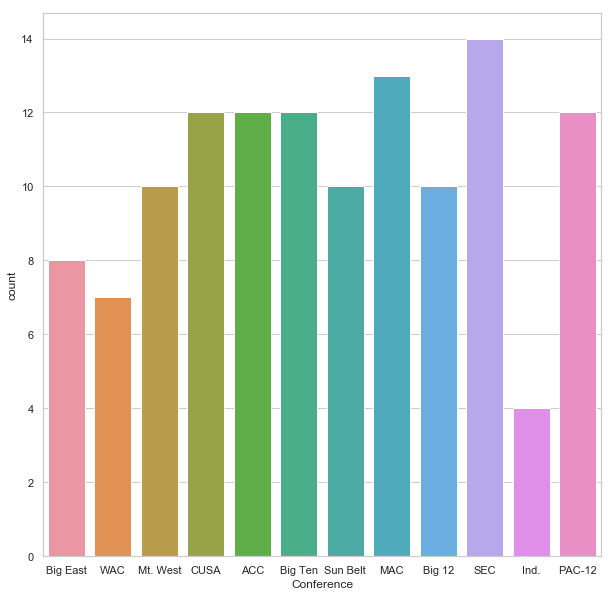

In [268]:
plot.subplots(figsize=(10,10))
sns.countplot(x="Conference", data=df1)

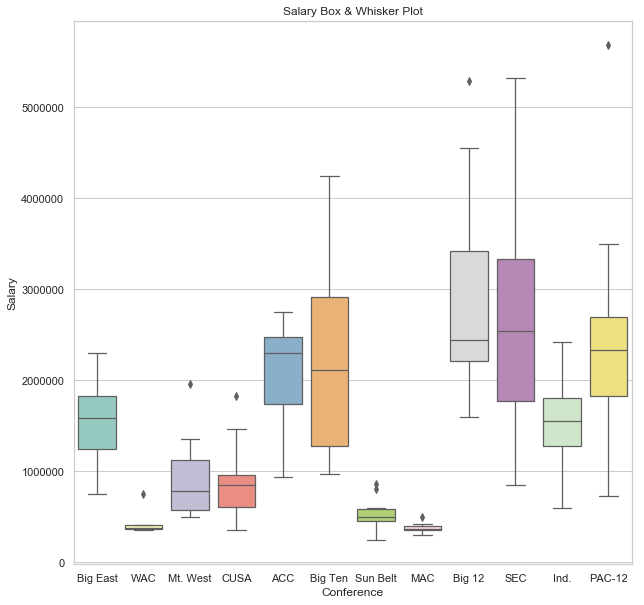

In [267]:
plot.subplots(figsize=(10,10))
sns.set(style="whitegrid")
plot1 = sns.boxplot(x='Conference', y='Salary', data=df1, palette = "Set3", 
                    linewidth=1.25).set_title('Salary Box & Whisker Plot')

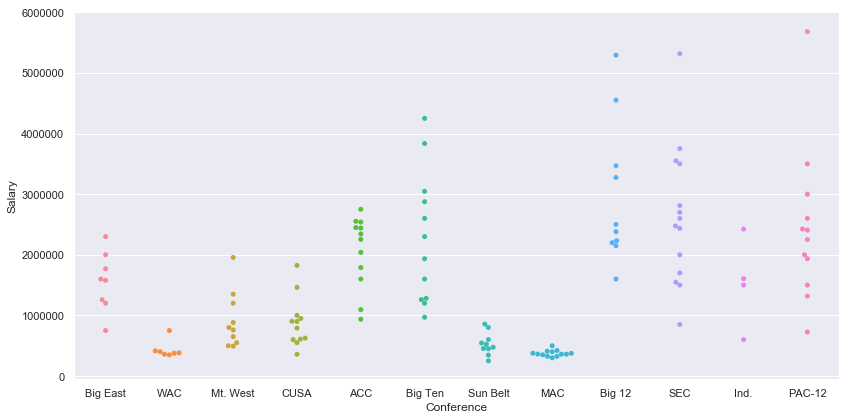

In [56]:
import seaborn as sns

sns.catplot(x="Conference", y="Salary", kind="swarm", data=df1,height=6, aspect=2)

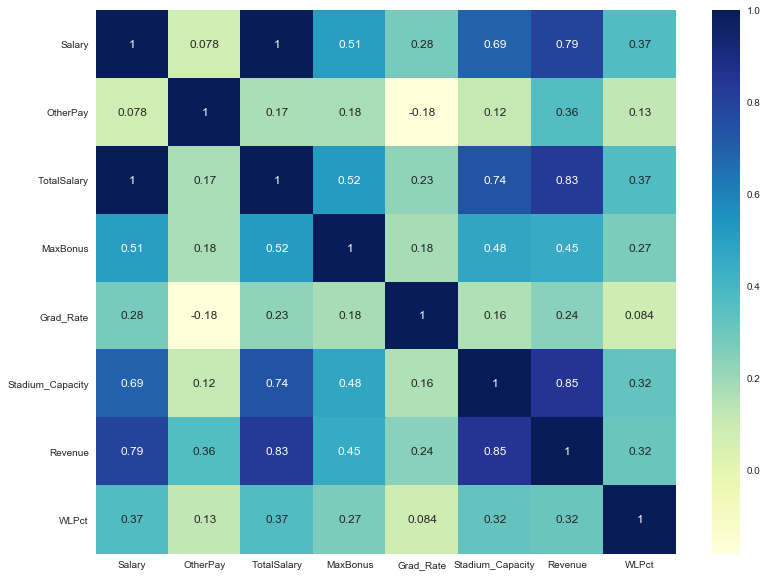

In [255]:
# Visualize correlations with a heatmap
plot.subplots(figsize=(13,10))
sns.heatmap(df1.drop(['latitude','longitude'], axis=1).corr(),
            annot=True,
            cmap="YlGnBu")

/Users/coreylucero/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/coreylucero/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


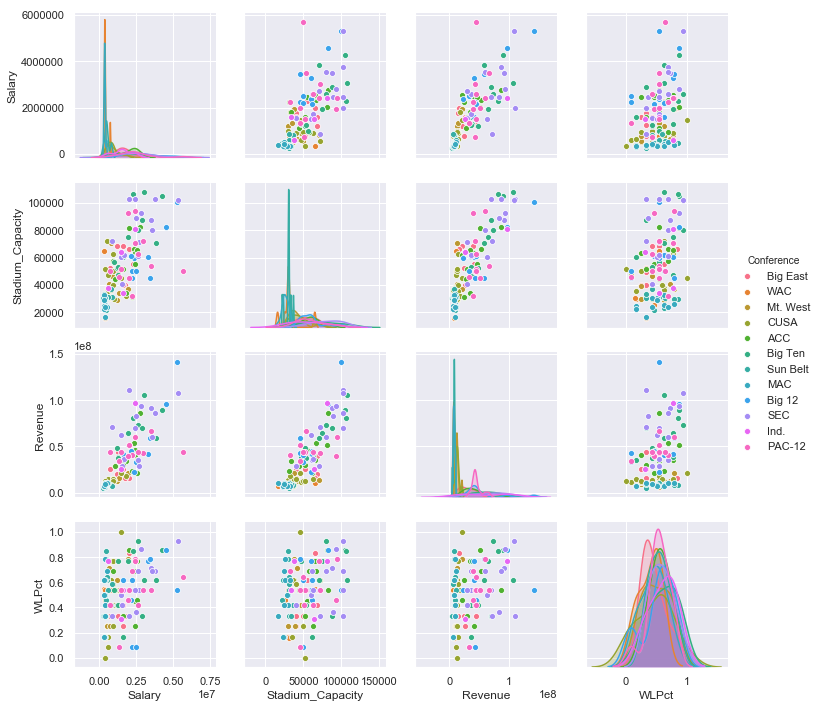

In [63]:
sns.pairplot(df1,
             vars=["Salary", "Stadium_Capacity","Revenue","WLPct"],
             hue="Conference")

## Data Modeling

In [233]:

# import packages for analysis and modeling
import pandas as pd  # data frame operations

import numpy as np  # arrays and math functions
from scipy.stats import uniform  # for training-and-test split
import statsmodels.api as sm  # statistical models (including regression)
import statsmodels.formula.api as smf  # R-like model specification
import matplotlib.pyplot as plt  # 2D plotting
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from patsy import dmatrices


In [81]:
np.random.seed(1234)
df1['runiform'] = uniform.rvs(loc = 0, scale = 1, size = len(df1))
df1_train = df1[df1['runiform'] >= 0.33]
df1_test = df1[df1['runiform'] < 0.33]

In [277]:
### OLS Regression Model built and used ###

lm_df = df1_train[['Salary', 'Revenue', 'Stadium_Capacity', 'WLPct', 'Conference']]
train_model_fit = smf.ols("Salary ~  Revenue + WLPct + Conference", lm_df).fit()

train_model_fit.predict(df1_test)
#1885813.85 is the recommended salary in Big East
#1259276 - Actual salary
df1_test

dfsyr = pd.DataFrame({'Conference':['ACC','Big Ten'], 'Salary': [1259276,1259276], 'Revenue': [44182377,44182377], 'Stadium_Capacity': [49250,49250], 'WLPct': .33})

train_model_fit.predict(dfsyr)
#ACC = 2,003,228
#Big Ten = 1,555,761
train_model_fit.summary()

#Revenue had the single greatest impact on R-squared - .723/.826

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     27.40
Date:                Sat, 04 Aug 2018   Prob (F-statistic):           9.23e-22
Time:                        12:05:09   Log-Likelihood:                -1207.9
No. Observations:                  83   AIC:                             2442.
Df Residuals:                      70   BIC:                             2473.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               7.181e+05   2.67e+05      2.692      0.009    1.86e+05    1.25e+06
Conference[T.Big 12]    3.535e+05   2.76e+05      1.280      0.205   -1.97e+05    9.04e+05
Conference[T.Big East] -1.199e+05   3.75e+05     -0.320      0.750   -8.67e+05    6.28e+05
Conference[T.Big Ten]  -4.688e+05   2.78e+05     -1.685      0.096   -1.02e+06     8.6e+04
Conference[T.CUSA]     -5.331e+05   2.87e+05     -1.860      0.067    -1.1e+06    3.84e+04
Conference[T.Ind.]     -2.169e-10   1.64e-10     -1.325      0.190   -5.44e-10     1.1e-10
Conference[T.MAC]      -9.896e+05   2.92e+05     -3.388      0.001   -1.57e+06   -4.07e+05
Conference[T.Mt. West] -5.872e+05   2.88e+05     -2.040      0.045   -1.16e+06    -1.3e+04
Conference[T.PAC-12]   -1.784e+05      3e+05     -0.596      0.553   -7.76e+05    4.19e+05
Conference[T.SEC]      -2.077e+05   2.84e+05     -0.730      0.468   -7.75e+05     3.6e+05
Conference[T.Sun Belt] -9.564e+05   3.03e+05     -3.161      0.002   -1.56e+06   -3.53e+05
Conference[T.WAC]      -8.729e+05   3.13e+05     -2.785      0.007    -1.5e+06   -2.48e+05
Revenue                    0.0238      0.003      7.104      0.000       0.017       0.030
WLPct                   9.423e+05   3.01e+05      3.131      0.003    3.42e+05    1.54e+06
==============================================================================
Omnibus:                        6.197   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.045   Jarque-Bera (JB):                6.914
Skew:                           0.366   Prob(JB):                       0.0315
Kurtosis:                       4.210   Cond. No.                     2.56e+24
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.86e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [285]:
#Final model used after model selection
final_model = smf.ols("Salary ~  Revenue + WLPct + Conference", df1).fit()
final_model.summary()

#final_model.predict(df1.iloc[[74]])
#Syracuse coach recommendation - $1,748,106


#final_model.predict(dfsyr)
#ACC - $2,006,831
#Big Ten - $1,686,848

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     23.66
Date:                Sat, 04 Aug 2018   Prob (F-statistic):           3.15e-25
Time:                        12:29:10   Log-Likelihood:                -1722.8
No. Observations:                 117   AIC:                             3474.
Df Residuals:                     103   BIC:                             3512.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               7.665e+05   2.69e+05      2.849      0.005    2.33e+05     1.3e+06
Conference[T.Big 12]     4.99e+05   2.85e+05      1.750      0.083   -6.67e+04    1.06e+06
Conference[T.Big East] -2.621e+05   3.01e+05     -0.871      0.386   -8.59e+05    3.35e+05
Conference[T.Big Ten]    -3.2e+05   2.84e+05     -1.127      0.262   -8.83e+05    2.43e+05
Conference[T.CUSA]     -6.024e+05   2.89e+05     -2.087      0.039   -1.17e+06   -2.99e+04
Conference[T.Ind.]     -6.112e+05   4.98e+05     -1.228      0.222    -1.6e+06    3.76e+05
Conference[T.MAC]      -1.025e+06   2.85e+05     -3.595      0.000   -1.59e+06    -4.6e+05
Conference[T.Mt. West] -6.425e+05   3.03e+05     -2.118      0.037   -1.24e+06    -4.1e+04
Conference[T.PAC-12]    2.045e+05   2.74e+05      0.746      0.457   -3.39e+05    7.48e+05
Conference[T.SEC]        -1.5e+05   2.76e+05     -0.544      0.587   -6.97e+05    3.97e+05
Conference[T.Sun Belt] -9.768e+05   3.03e+05     -3.225      0.002   -1.58e+06   -3.76e+05
Conference[T.WAC]      -8.979e+05    3.3e+05     -2.722      0.008   -1.55e+06   -2.44e+05
Revenue                    0.0204      0.004      5.770      0.000       0.013       0.027
WLPct                   1.022e+06   2.95e+05      3.464      0.001    4.37e+05    1.61e+06
==============================================================================
Omnibus:                       42.922   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              191.613
Skew:                           1.143   Prob(JB):                     2.46e-42
Kurtosis:                       8.838   Cond. No.                     5.53e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.53e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [287]:
### OLS Regression model built to evaluate impact of graduation rate ###
lm_df2 = df1_train[['Salary', 'Revenue', 'Stadium_Capacity', 'WLPct', 'Conference', 'Grad_Rate']]
train_model_fit2 = smf.ols("Salary ~ Revenue + WLPct + Conference + Grad_Rate", lm_df2).fit()

train_model_fit2.summary()

#Graduation rate is not significant in predicting salary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     24.93
Date:                Sat, 04 Aug 2018   Prob (F-statistic):           4.93e-21
Time:                        12:31:43   Log-Likelihood:                -1207.9
No. Observations:                  83   AIC:                             2444.
Df Residuals:                      69   BIC:                             2478.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               5.939e+05    1.1e+06      0.542      0.590   -1.59e+06    2.78e+06
Conference[T.Big 12]    3.577e+05   2.81e+05      1.275      0.207   -2.02e+05    9.17e+05
Conference[T.Big East] -1.165e+05   3.79e+05     -0.308      0.759   -8.72e+05    6.39e+05
Conference[T.Big Ten]  -4.687e+05    2.8e+05     -1.673      0.099   -1.03e+06    9.02e+04
Conference[T.CUSA]     -5.299e+05    2.9e+05     -1.828      0.072   -1.11e+06    4.85e+04
Conference[T.Ind.]       2.55e-10   1.09e-10      2.329      0.023    3.66e-11    4.73e-10
Conference[T.MAC]      -9.824e+05   3.01e+05     -3.268      0.002   -1.58e+06   -3.83e+05
Conference[T.Mt. West] -5.774e+05   3.02e+05     -1.914      0.060   -1.18e+06    2.45e+04
Conference[T.PAC-12]   -1.721e+05   3.06e+05     -0.562      0.576   -7.83e+05    4.39e+05
Conference[T.SEC]      -2.017e+05   2.91e+05     -0.693      0.491   -7.82e+05    3.79e+05
Conference[T.Sun Belt] -9.457e+05   3.18e+05     -2.972      0.004   -1.58e+06   -3.11e+05
Conference[T.WAC]      -8.633e+05   3.26e+05     -2.646      0.010   -1.51e+06   -2.12e+05
Revenue                    0.0238      0.003      7.049      0.000       0.017       0.031
WLPct                   9.417e+05   3.03e+05      3.106      0.003    3.37e+05    1.55e+06
Grad_Rate               1401.0275    1.2e+04      0.117      0.907   -2.25e+04    2.53e+04
==============================================================================
Omnibus:                        6.187   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.045   Jarque-Bera (JB):                6.893
Skew:                           0.366   Prob(JB):                       0.0319
Kurtosis:                       4.207   Cond. No.                     1.92e+24
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.09e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Final Conclusions and Recommendations

The analysis led to the following conclusions:
* Although the data was not all temporally aligned, this academic exercise shows that an ordinary-least-squares model can be used to predict an NCAA coaches football salary. 
* The model managed to maintain the integrity of the data by not eliminating any schools from the analysis for the final model.
* Graduation rate of the athletes was not a significant variable in predicting coach salaries.
* By eliminating each variable one-by-one I determined ‘Revenue’ had the single greatest impact on R2 making it the most important single variable in predicting salary.
* Based on the data for the Syracuse head coach - Big East conference, Revenue of 42.1 million and a win-loss percentage of .333, I would recommend a salary of 1,748,107 to be competitive with peer institutions. This information is not 100% accurate to 2018 Syracuse figures, but would mean a major cut to Dino Baber’s current 2.8 million annual salary. (Sorry Dino!).
* If we change the Syracuse conference to the ACC, as is current in 2018, the recommended salary would increase to a base salary of 2,006,831. But if Syracuse hypothetically moved to the Big Ten the recommended salary would decrease to a base salary of 1,686,848.
